In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from mouselab import MouselabEnv
import networkx as nx
from distributions import Categorical
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tf_agents.environments import gym_wrapper
from tf_agents.environments import utils
from tf_agents.distributions.utils import SquashToSpecNormal
from tf_agents.environments import tf_py_environment
from metamdpfunctions import *

tf.compat.v1.enable_v2_behavior()

#ppo_utils.nested_kl_divergence = nested_kl_divergence_new
#This line is absolutely crucial, it replaces the nested_kl_divergence function defined in ppo_utils by the one 
#we wrote in metamdpfunctions

%load_ext autoreload
%autoreload 2

In [2]:
def plot_graph(graph,s=None):
    G = nx.Graph()
    for i,e in enumerate(graph['edges']):
        G.add_edge(e[0],e[1],label=i)
    edge_order = np.array(list(nx.get_edge_attributes(G,'label').values()))
    pos = nx.spring_layout(G)
    intermediate_nodes = list(range(max(sum(graph['edges'],[]))+1))
    if "start" in graph:
        intermediate_nodes.remove(graph["start"])
    if "goal" in graph:
        intermediate_nodes.remove(graph["goal"])
    nx.draw_networkx_nodes(G,pos,nodelist = intermediate_nodes,node_color = "C0")  
    if "start" in graph:
        nx.draw_networkx_nodes(G,pos,nodelist = [graph["start"]],node_color = "C1")
    if "goal" in graph:
        nx.draw_networkx_nodes(G,pos,nodelist = [graph["goal"]],node_color = "C2")
    if not s is None:
        edge_color_dict = {-1: 'r', 0 : 'k', 1: 'g'}
        edge_colors = [edge_color_dict[e] for e in np.array(s)[edge_order]]
        edge_widths = 3-2*(np.array(s)[edge_order]==0)
        nx.draw_networkx_edges(G,pos,edge_color=edge_colors,width = edge_widths)
    else:
        nx.draw_networkx_edges(G,pos,edge_color='k')
    nx.draw_networkx_labels(G,pos)
    #plt.gca().set_aspect('equal')
    c = np.array(list(pos.values()))
    plt.gca().set_xlim(np.min(c[:,0])-0.2,np.max(c[:,0])+0.2)
    plt.gca().set_ylim(np.min(c[:,1])-0.2,np.max(c[:,1])+0.2)
    plt.gca().set_frame_on(False)
    plt.show()

In [3]:
def get_graph(env):
    return {"start" : 0, "edges" : sum([[[i,j] for j in jj] for i,jj in (enumerate(env.tree))],[])}

In [4]:
val_dist = Categorical([-10,-5,5,10],[0.25, 0.25, 0.25, 0.25])

def encode_state_as_tensor(state):
    if isinstance(state,str) and state=='__term_state__':
        return np.zeros([12,4]).astype(np.float32)
    return np.vstack([np.array(d.probs) if isinstance(d,Categorical) else 
                      np.array(val_dist.vals==d).astype(np.float32) for d in state[1:]])

def load_environment(params):
    return gym_wrapper.GymWrapper(MouselabEnv.new_symmetric([3,1,2],val_dist,encode_state_as_tensor=encode_state_as_tensor))

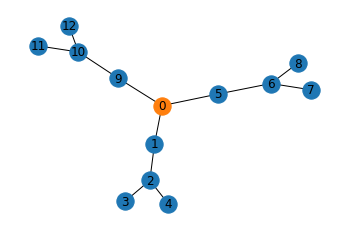

In [5]:
env = load_environment(params=None)
graph = get_graph(env)
plot_graph(graph)

In [6]:
env.reset()
env.step(0)
env.step(1)

TimeStep(step_type=array(0), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25]], dtype=float32))

In [8]:
env.observation_spec()

BoundedArraySpec(shape=(12, 4), dtype=dtype('float32'), name='observation', minimum=0.0, maximum=1.0)

In [9]:
test_environment(env,1,0)

ObservationSpec: BoundedArraySpec(shape=(12, 4), dtype=dtype('float32'), name='observation', minimum=0.0, maximum=1.0)
ActionSpec: BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=12)
0.0
0.0
-30.0
-30.0
-30.0
-60.0
-60.0
-60.0
-90.0
-90.0
-90.0
-85.0
Final Reward =  -85.0


In [10]:
N=10
learning_rate = 0.001
replay_buffer_capacity = 1000 #the amount of steps (not episodes) saved in the buffer
value_fc_layers = (2*N,2*N,2*N) #the number of units in the intermediate (dense) layers of the value network
actor_fc_layers = (2*N,2*N,2*N) #the number of units in the intermediate (dense) layers of the actor network
num_eval_episodes = 100 #the number of episode to average over when computing reward for the stochastic policy
num_iterations = 1
collect_episodes_per_iteration = 30 # the number of episodes to collect per iteration
log_interval = 100 #how often to log the loss
eval_interval = 100 #how often to calculate and log returns
policy_checkpoint_interval = None#25000 # how often to save the policy
num_epochs = 1 #number of training steps to take per batch of episodes
method = 'PPO'

train_py_env = load_environment(params=None)
eval_py_env = load_environment(params=None)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

tf_agent = load_ppo_agent(train_env,actor_fc_layers,value_fc_layers,learning_rate,num_epochs)
    
direc = 'test/'
tf_agent,returns,losses = train_agent(tf_agent,train_env,eval_env,num_iterations,[],[],collect_episodes_per_iteration,log_interval,eval_interval,policy_checkpoint_interval,replay_buffer_capacity,num_eval_episodes,direc)


Instructions for updating:
SeedStream has moved to `tfp.util.SeedStream`.
step = 0: Average Collection Return = -17.0
step = 0: Average Collection Length = 4.54
step = 0: loss = 278.47906494140625


In [16]:
ts = eval_env.reset()
while not ts.is_last():
    print("V(state)",tf_agent._value_net(ts.observation)[0].numpy())
    print("pi(state)",list(enumerate(tf_agent.collect_policy.distribution(ts).action.prob(np.arange(13)).numpy().round(3))))
    action = tf_agent.collect_policy.action(ts).action
    print(action.numpy())
    ts = eval_env._step(action)


V(state) [-0.00259087]
pi(state) [(0, 0.081), (1, 0.077), (2, 0.075), (3, 0.078), (4, 0.078), (5, 0.076), (6, 0.077), (7, 0.077), (8, 0.075), (9, 0.077), (10, 0.077), (11, 0.075), (12, 0.077)]
[1]
V(state) [0.00016868]
pi(state) [(0, 0.081), (1, 0.077), (2, 0.075), (3, 0.079), (4, 0.077), (5, 0.076), (6, 0.075), (7, 0.077), (8, 0.075), (9, 0.077), (10, 0.077), (11, 0.076), (12, 0.076)]
[2]
V(state) [-0.00094232]
pi(state) [(0, 0.08), (1, 0.076), (2, 0.077), (3, 0.08), (4, 0.076), (5, 0.077), (6, 0.076), (7, 0.076), (8, 0.076), (9, 0.077), (10, 0.077), (11, 0.075), (12, 0.077)]
[5]
V(state) [0.00433902]
pi(state) [(0, 0.079), (1, 0.076), (2, 0.078), (3, 0.08), (4, 0.076), (5, 0.077), (6, 0.075), (7, 0.077), (8, 0.077), (9, 0.075), (10, 0.077), (11, 0.074), (12, 0.078)]
[0]


In [44]:
print("V(initial state)",tf_agent._value_net(ts.observation))

V(initial state) (<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.00799456], dtype=float32)>, ())


In [38]:
ts.observation

array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25]], dtype=float32)

In [43]:
import distributions
import functools

val_dist = Categorical([-1,-0.5,0.5,1],[0.25, 0.25, 0.25, 0.25])

def max_of_categoricals(d1,d2):
    return distributions.cross((d1, d2), lambda s, o: max(s,o))
    
d = (val_dist + val_dist + max_of_categoricals(val_dist,val_dist))
functools.reduce(max_of_categoricals,[d,d,d]).expectation()

1.5311846733093262

In [41]:
d.expectation()

0.4375